# Chronic Kidney Disease (CKD) Prediction

In this analysis I will explore various predictive algorithims for predicting CKD.  The goals of this project include:
- Comparing various models to determine which is most effective for this use case.
- Given the imbalanced data & nature of the example problem (i.e. disease detection), demonstrate the importance of utilizing the correct model evaluation metrics & their implications on the overall business outcome.

<font color = orange> **This is a work in progress; stay tuned for more improvements to come.  Future scope and updates to be made are outlined at the end of this notebook**
___

**Import the necessary packages**

In [1]:
## Standard Packages
import pandas as pd
import numpy  as np

## Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## EDA & preprocessing
from sklearn.impute import KNNImputer
from scipy import stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency 
from sklearn import preprocessing

## Modeling 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import GridSearchCV


## Set options to view all columns of dataframes
pd.set_option('max_columns', None)

**Define custom functions used throughout analysis**

In [2]:
def check_missing_data(df):
    
    """
    This function will print the data types and number of missing values for each variable, and display a heatmap to visualize the missing values
    
    Inputs:
    df - dataframe to check for missing values 
    """
        
    ## Set figure size
    plt.figure(figsize = (12, 8))

    ## Create heatmap to visualize 
    sns.heatmap(df_orig.isnull(), yticklabels = False, cbar = False, cmap = 'BuGn_r')
    plt.title('Review Amount of Missing Data - Filtered Dataset', size = 15)    
    plt.show()
    
    ## Print data types and number of missing values for each variable
    df_orig.info()


In [3]:
def model_eval(Model, y_actual, y_predictions):

   
    """
    This fuctions returns a confusion matrix & evaluation metrics, & the profit 
    
    - Correct identification of sick patients (True Positives) result in profit of $13000
    - Incorrectly predicting a healthy patient has CKD (False Positives) costs $100
    - Incorrectly predicting a sick patient is health (False Negaties) carries the greatest risk in disease identification. 
        First and foremost, it puts the patient's life at risk.  From a business perspective, this can lead to the chance of costly lawsuit.
        Therefore, an estimation of the chance of (1%) and cost from ($300k) is also added to the model evaluation 

    """

    ##################### Confusion Matrix #####################   
    conf_mat = pd.DataFrame(confusion_matrix(y_actual, y_predictions),
                            index = Model.classes_, columns = Model.classes_)  


    ################ Calculate Net Profit ################
    ## Correct identification of sick patients (true positives) result in profit of 13000   
    ##
    
    # profit = conf_mat.iloc[1,1]*13000 - conf_mat.iloc[0,1]*100
    profit = conf_mat.iloc[1,1]*13000 - conf_mat.iloc[0,1]*100 - (conf_mat.iloc[1,0]*.01*300000) 
    
    ################ Classification Report DataFrame ################
    ## Create Dataframe (contains Precision, Recall, F1, Support)
    report = pd.DataFrame(list(precision_recall_fscore_support(y_actual, y_predictions)),
                index=['Precision', 'Recall', 'F1-score', 'Support']).T

    ## Re-label indexes to match label of classes
    report.set_index(Model.classes_, inplace=True)

    ## Add the 'Avg/Total' row
    report.loc['Avg/Total', :] = precision_recall_fscore_support(y_actual, y_predictions, average='weighted')
    report.loc['Avg/Total', 'Support'] = report['Support'].sum()

    ## Round Results
    report = report.round(2)

    print("Confusion Matrix: \n", conf_mat, '\n')    
    print('Proft: ', profit) 
    print('F1 Score: ', report.loc['Avg/Total', 'F1-score'], '\n')
    print('Model Results:')

    return report   

In [4]:
# model_eval(model_LR_all, y_test, predictions_LR_all)

In [28]:
def model_eval_for_df(Model_Name, Model, y_actual, y_predictions):

   
    """
    This fuctions returns a the F1 score, AUC & profit; same approach as prior function, but returns the evaluation metrics to put into a dataframe

    Calculating Profit
    - Correct identification of sick patients (True Positives) result in profit of $13000
    - Incorrectly predicting a healthy patient has CKD (False Positives) costs $100
    - Incorrectly predicting a sick patient is health (False Negaties) carries the greatest risk in disease identification. 
        First and foremost, it puts the patient's life at risk.  From a business perspective, this can lead to the chance of costly lawsuit.
        Therefore, an estimation of the chance of (1%) and cost from ($300k) is also added to the model evaluation 

    
    Model_Name: input 

    """

    ##################### Confusion Matrix #####################   
    conf_mat = pd.DataFrame(confusion_matrix(y_actual, y_predictions),
                            index = Model.classes_, columns = Model.classes_)  


    ################ Calculate Profit ################
    # profit = conf_mat.iloc[1,1]*13000 - conf_mat.iloc[0,1]*100
    profit = conf_mat.iloc[1,1]*13000 - conf_mat.iloc[0,1]*100 - (conf_mat.iloc[1,0]*.01*300000) 
    
    ################ Classification Report DataFrame ################
    ## Create Dataframe (contains Precision, Recall, F1, Support)
    report = pd.DataFrame(list(precision_recall_fscore_support(y_actual, y_predictions)),
                index=['Precision', 'Recall', 'F1-score', 'Support']).T

    ## Re-label indexes to match label of classes
    report.set_index(Model.classes_, inplace=True)

    ## Add the 'Avg/Total' row
    report.loc['Avg/Total', :] = precision_recall_fscore_support(y_actual, y_predictions, average='weighted')
    report.loc['Avg/Total', 'Support'] = report['Support'].sum()

    ## Round Results
    report = report.round(2)
    
    ## Calc AUC
    AUC = np.round(roc_auc_score(y_actual, y_predictions), 3)

#     print('Proft: ', profit) 
#     print('F1 Score: ', report.loc['Avg/Total', 'F1-score'], '\n')

    return [Model_Name, report.loc['Avg/Total', 'F1-score'], AUC, profit]   

**Import data**

In [6]:
## Import dataset
df_orig = pd.read_csv('CKD Data_Original.csv')

df_orig.head()

,ID,Age,Female,Racegrp,Educ,Unmarried,Income,CareSource,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD
0,1,65,1,white,0.0,0.0,1.0,other,1.0,56.0,162.1,21.31,0.0,83.6,135.0,71.0,48.0,249.0,297.0,0,0,3.0,0.0,1,0.0,0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0
1,2,36,1,hispa,0.0,NaN,1.0,noplace,0.0,60.2,162.2,22.88,0.0,76.6,96.0,52.0,31.0,135.0,166.0,0,0,3.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,66,1,white,0.0,1.0,0.0,noplace,1.0,83.9,162.5,31.77,1.0,113.2,115.0,57.0,44.0,211.0,255.0,1,0,1.0,0.0,1,0.0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,54,1,white,1.0,0.0,0.0,DrHMO,1.0,69.4,160.5,26.94,0.0,77.9,110.0,57.0,74.0,156.0,230.0,0,0,2.0,0.0,1,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,63,1,black,0.0,0.0,NaN,clinic,1.0,73.1,159.2,28.84,0.0,89.3,132.0,73.0,67.0,154.0,221.0,0,0,1.0,0.0,0,1.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


___

# 1 -- Data Preparation & Exploratory Data Analysis (EDA)

### 1(a) -- Handling missing data

The first step in preparing the data for exploration is often reviewing for missing data

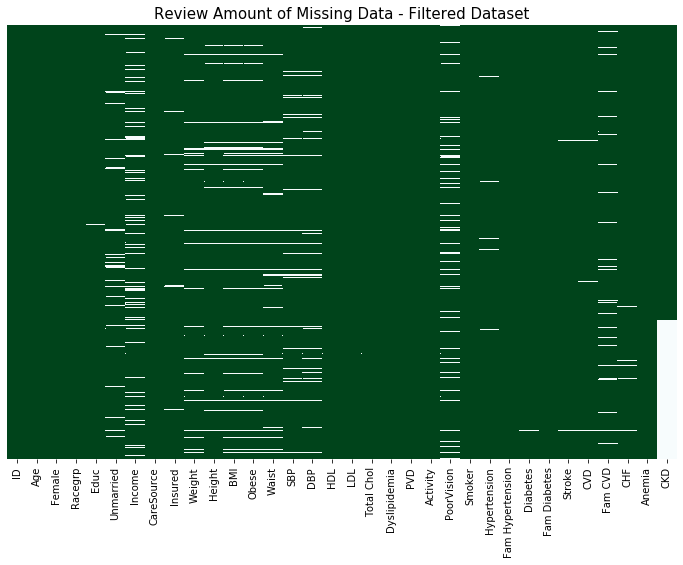

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8819 entries, 0 to 8818
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8819 non-null   int64  
 1   Age               8819 non-null   int64  
 2   Female            8819 non-null   int64  
 3   Racegrp           8819 non-null   object 
 4   Educ              8799 non-null   float64
 5   Unmarried         8367 non-null   float64
 6   Income            7653 non-null   float64
 7   CareSource        8819 non-null   object 
 8   Insured           8706 non-null   float64
 9   Weight            8625 non-null   float64
 10  Height            8628 non-null   float64
 11  BMI               8529 non-null   float64
 12  Obese             8529 non-null   float64
 13  Waist             8505 non-null   float64
 14  SBP               8511 non-null   float64
 15  DBP               8439 non-null   float64
 16  HDL               8802 non-null   float64


In [7]:
check_missing_data(df_orig)

- The ID column is not needed as it does not provide any analytical value.  This column will be dropped.
- The target variable (CKD) is missing values.  For supervised learning, we can only work with the observations for which a label is available. Therefore, the dataset must be reduced to those 6,000 rows for which the label is available.

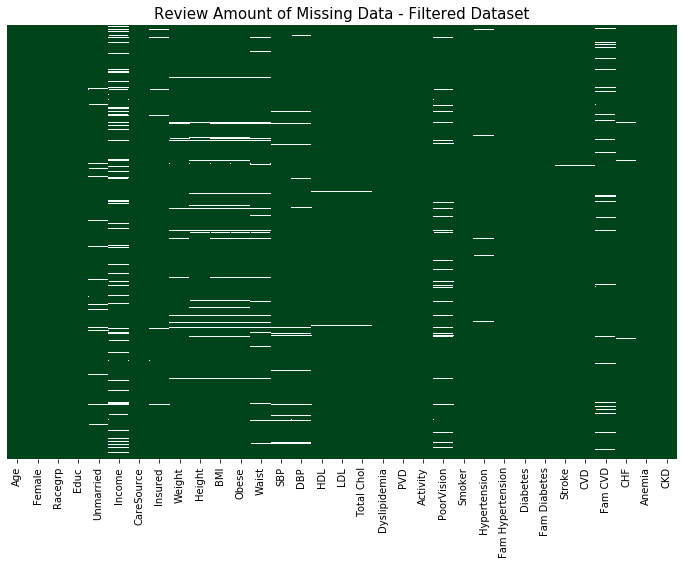

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               6000 non-null   int64  
 1   Female            6000 non-null   int64  
 2   Racegrp           6000 non-null   object 
 3   Educ              5985 non-null   float64
 4   Unmarried         5699 non-null   float64
 5   Income            5208 non-null   float64
 6   CareSource        6000 non-null   object 
 7   Insured           5922 non-null   float64
 8   Weight            5867 non-null   float64
 9   Height            5861 non-null   float64
 10  BMI               5794 non-null   float64
 11  Obese             5794 non-null   float64
 12  Waist             5785 non-null   float64
 13  SBP               5794 non-null   float64
 14  DBP               5748 non-null   float64
 15  HDL               5992 non-null   float64
 16  LDL               5992 non-null   float64


In [8]:
## Drop ID column
df_orig.drop('ID', axis = 1, inplace = True)

## Reduce the dataset to observations for which the target is available
df_orig = df_orig[df_orig['CKD'].notnull()]

check_missing_data(df_orig)

There are multiple options for handling missing data, each with its own pros and/or cons to be considered:

- Remove rows with missing values
    - Drawback: This results in information loss as it removes valuable data on which the model can be trained.

- Fill missing values with mean or mode of that given column
    - Drawback:  values imputed for a given row (i.e. a given patient in this analysis) will not be specific or personalized to that given observation.  The mean can be influenced by outliers of dissimilar observations.  This can also impact the correlation between features.
    
- ***Impute using KNN***:  instead of using the mean of the entire column to fill all missing values, this method uses a more customized approach for each missing value.  For an observation's  missing value, this method will first find a given number (K) of the most similar observations based on the data for other features, then impute the mean of the missing feature across just those K similar observations
    - Benefit: Imputation of missing values is more specific to a given observation rather than being generalized based on the entire dataset 
    

Based on these considerations, I will use KNN imputation to fill the missing data.  
There are, however, various considerations that need to be taken into account in how the data is prepared for imputation.
- Imputer can only work with numeric values.  Therefore, I will exclude any columns that are strings (data type = object); (excludes Race Group, Care Source).  Fortunately , neither of these columns have missing values.  
- The values for categorical variables will need to be discrete numbers (i.e. integers).  Calculating averages will lead to the imputed results being decimal values.  In these instances, decimalvalues will be rounded to nearest integer.

In [9]:
## Create lists of the columns by type
continuous_cols = ['Age', 'SBP', 'DBP', 'HDL', 'LDL', 'Total Chol', 'Waist', 'Weight', 'Height', 'BMI']
categorical_cols = list(np.setdiff1d(df_orig.columns, continuous_cols))

## Create list of columns that will be used in imputation (string columns)
cols_to_impute = [col  for col in df_orig.columns if df_orig[col].dtype != 'O']

## Create list of columns that will NOT be used (will need to be kept separate in order to join whole datasetback together)
#   not used because of data type (string)
string_cols = [col  for col in df_orig.columns if df_orig[col].dtype == 'O']

## Create imputer instance; define N neighbors
imputer = KNNImputer(n_neighbors = 10)

## Fit imputer to data; save new arrays with imputed values
imputed_values = imputer.fit_transform(df_orig[cols_to_impute])

## Save new dataframe with imputed values
df_imputed = pd.DataFrame(imputed_values, columns = cols_to_impute)

## Add back the columns that were not used in imputation (columns in which the values are strings).  
## There were no missing values in these columns
df_imputed = pd.concat([df_orig[string_cols], df_imputed], axis = 1)

## Make list of columns that need to be converted to integers.  Convert those columns to integers
discrete_to_round = list(np.setdiff1d(list(np.setdiff1d(df_orig.columns, continuous_cols)), string_cols))
df_imputed[discrete_to_round] = df_imputed[discrete_to_round].astype(int)

df_imputed.head()

,Racegrp,CareSource,Age,Female,Educ,Unmarried,Income,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD
0,white,other,65.0,1,0,0,1,1,56.0,162.1,21.31,0,83.6,135.0,71.0,48.0,249.0,297.0,0,0,3,0,1,0,0,0,1,0,1,0,0,0,0
1,hispa,noplace,36.0,1,0,0,1,0,60.2,162.2,22.88,0,76.6,96.0,52.0,31.0,135.0,166.0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
2,white,noplace,66.0,1,0,1,0,1,83.9,162.5,31.77,1,113.2,115.0,57.0,44.0,211.0,255.0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0
3,white,DrHMO,54.0,1,1,0,0,1,69.4,160.5,26.94,0,77.9,110.0,57.0,74.0,156.0,230.0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0
4,black,clinic,63.0,1,0,0,0,1,73.1,159.2,28.84,0,89.3,132.0,73.0,67.0,154.0,221.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


### 1(b) -- Distributions
**1(b.1) -- Distributions of Target Variable**

Reviewing the distribution of the dependent variable, it can be seen that we are working with an imbalanced classification problem - the positive cases are only a very small portion (approximately 7%) of the overall dataset.  


When modeling imbalanced data, it is especially important to consider the evaluation metrics used to assess the model's predictive performance.  For example, predicting all patients do not have CKD will yield high accuracy as a large percentage of the predictions will be correct.  However, in most (all?) business scenarios - - the primary goal of the model is effective identifcation of either outcome on a case by case basis over achieving a high accuracy score. This is especially true in the use case in this analysis (i.e. disease detection) in which identifying the positive cases is quite literally a matter of life and death.  Therefore,  it is important to assess metrics that consider the model's overall effectiveness in classifying either outcome, such as precision, recall, & F1 score.


 % positive cases 7.7%


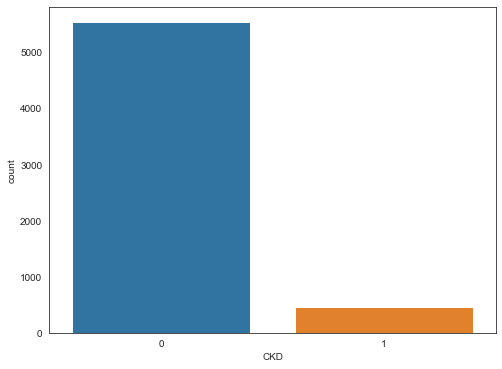

In [10]:
plt.figure(figsize=(8,6))
sns.set_style('white')

print('\n', '% positive cases', str(round(df_imputed['CKD'].astype(int).mean()*100, 1)) + '%')

sns.countplot(df_imputed['CKD'])
plt.show()

**1(b.2) -- Distributions of Features**

Put very (too) simply, the goal of classification problems is to distinguish between 2 (or more) classes
In classificiation problems, we are trying to make a clear distinction between 2 (or more) classes.  Therefore, variables for which there is a greater distinction in the distributions between the classes are likely to be better predictors of the classifications.

<font color = grey> 
Variables with more noticable differences are:
- Age
- SBP
- Waist

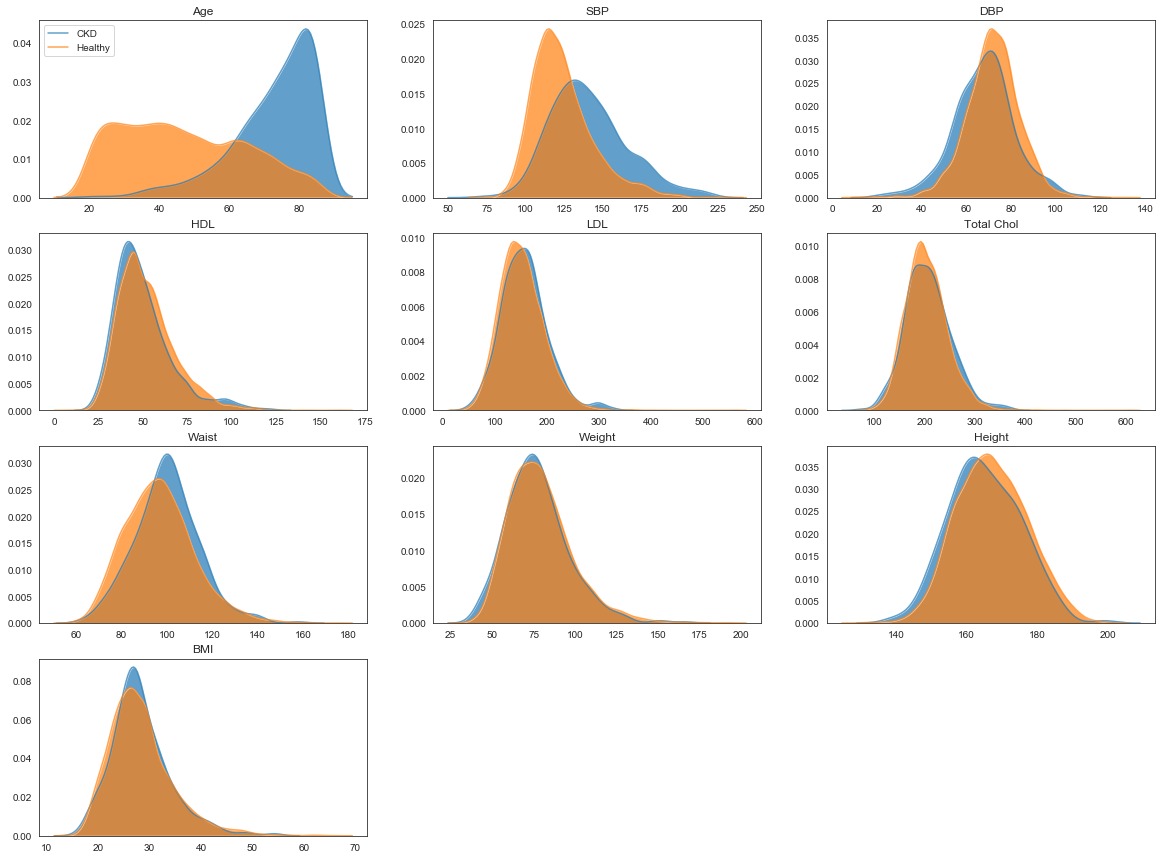

In [11]:
al = .7

plt.figure(figsize=(20,15))

for i, var in enumerate(df_imputed[continuous_cols]):
    plt.subplot(4, 3, i+1)

    sns.kdeplot(df_imputed[df_imputed['CKD'] == 1][var], shade = True, alpha = al, label = 'CKD')
    sns.kdeplot(df_imputed[df_imputed['CKD'] == 0][var], shade = True, alpha = al, label = 'Healthy')    

    plt.title(var)

    if i == 0:
        plt.legend(loc='upper left')
    else:
        plt.legend().remove()


### 1(c) -- Feature Relationships
**1(c.1) -- Correlations**

Another important step in EDA and feature engineering is to check to see if any combination of variables are highly correlated, i.e. review for **multicollinearity**.

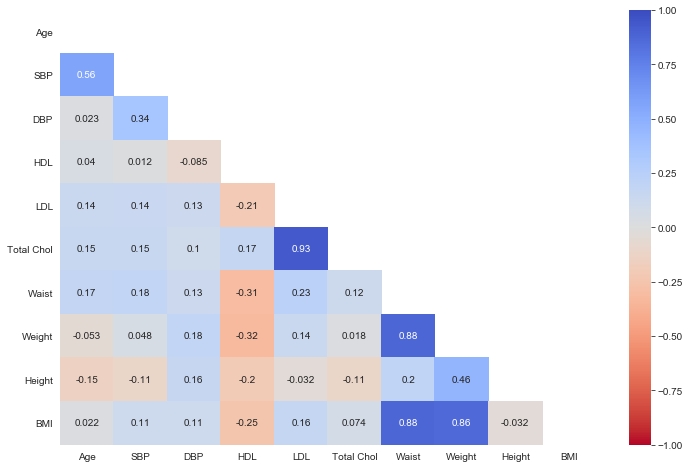

In [12]:
## Set size of plot
plt.figure(figsize = (12, 8))

## Get correlation
corr  = df_imputed[continuous_cols].corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm_r', annot = True, mask = mask)
plt.show()

Takeaway
- Weight, Height, Waist, BMI highly correlated.  
    - Use BMI, considers all as inputs

Investigate Highly correlated values (> .5)
- SBP (drop) : Age (keep)
- Total.Chol (keep) : LDL (drop)
- Waist (keep): Weight (drop)
- Waist (keep): BMI (drop)
- Weight (drop): BMI (drop)

**Categorical**

**1(c.2) -- Categorical Features (Chi-Square Test)**

The Chi-Square test can be used to test if there is a "significant" relationship between a given categorical variable and the target feature, which can help determine if  the variabe is relevant to the outcome being predicted. If there is no relationship, the variable and target are deemed independent of each other; therefore the given variable can be reasonably excluded from model.

In [13]:
## Create shell of dataframe for results
df_chi2 = pd.DataFrame(index = categorical_cols, columns = ['p-value', 'Outcome'])

## Assign p-value to use to test null
alpha = 0.05

## Iterate through categorical variables
for col in categorical_cols:
    
    ## Create contingency table comparing given variable and the target
    contingency_table = pd.crosstab(df_imputed[col], df_imputed['CKD'])

    ## Run Test
    stat, p, dof, expected = chi2_contingency(contingency_table) 
    
    ## Add results to dataframe    
    df_chi2.loc[col, 'p-value'] = np.round(p, 3)
    if p <= alpha:
        df_chi2.loc[col, 'Outcome'] = 'Dependent'
    else:
        df_chi2.loc[col, 'Outcome'] = 'Independent'
    

## Display variables that can be excluded
print('Variables to exclude:',  list(df_chi2[df_chi2['Outcome'] == 'Independent'].index))
    
df_chi2   

Variables to exclude: ['Dyslipidemia', 'Fam Diabetes', 'Female', 'Obese']


,p-value,Outcome
Activity,0,Dependent
Anemia,0,Dependent
CHF,0,Dependent
CKD,0,Dependent
CVD,0,Dependent
CareSource,0,Dependent
Diabetes,0,Dependent
Dyslipidemia,0.951,Independent
Educ,0,Dependent
Fam CVD,0.001,Dependent


# 2 -- Modeling

### 2(a.1) -- Data Prep: Variable Encoding

The dataset contains features for which the data are strings, which can not be used in model training as-is.  Therefore, I will use **One-Hot Encoding** to transform the feature to numeric representations that can be interpreted in model training.

There are two 

In [14]:
df_imputed.head(2)

,Racegrp,CareSource,Age,Female,Educ,Unmarried,Income,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD
0,white,other,65.0,1,0,0,1,1,56.0,162.1,21.31,0,83.6,135.0,71.0,48.0,249.0,297.0,0,0,3,0,1,0,0,0,1,0,1,0,0,0,0
1,hispa,noplace,36.0,1,0,0,1,0,60.2,162.2,22.88,0,76.6,96.0,52.0,31.0,135.0,166.0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
## Create dummy columns for each of the categorical variables
df_dummies_race = pd.get_dummies(df_imputed['Racegrp'], columns = list(df_imputed['Racegrp'].unique()), prefix = 'Race')
df_dummies_caresrc = pd.get_dummies(df_imputed['CareSource'], columns = list(df_imputed['Racegrp'].unique()), prefix = 'CareSrc')

## Add new dummy columns to original dataframe
df_final = pd.concat([df_imputed, df_dummies_race, df_dummies_caresrc], axis = 1)

## Drop original version of categorical columns
df_final.drop(['Racegrp', 'CareSource'], axis = 1, inplace = True)

df_final.head()

,Age,Female,Educ,Unmarried,Income,Insured,Weight,Height,BMI,Obese,Waist,SBP,DBP,HDL,LDL,Total Chol,Dyslipidemia,PVD,Activity,PoorVision,Smoker,Hypertension,Fam Hypertension,Diabetes,Fam Diabetes,Stroke,CVD,Fam CVD,CHF,Anemia,CKD,Race_black,Race_hispa,Race_other,Race_white,CareSrc_,CareSrc_DrHMO,CareSrc_clinic,CareSrc_noplace,CareSrc_other
0,65.0,1,0,0,1,1,56.0,162.1,21.31,0,83.6,135.0,71.0,48.0,249.0,297.0,0,0,3,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,36.0,1,0,0,1,0,60.2,162.2,22.88,0,76.6,96.0,52.0,31.0,135.0,166.0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,66.0,1,0,1,0,1,83.9,162.5,31.77,1,113.2,115.0,57.0,44.0,211.0,255.0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,54.0,1,1,0,0,1,69.4,160.5,26.94,0,77.9,110.0,57.0,74.0,156.0,230.0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,63.0,1,0,0,0,1,73.1,159.2,28.84,0,89.3,132.0,73.0,67.0,154.0,221.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


**Additional feature considerations:**
- Activity:  This is a categorical variable. While the underlying values variable are numeric, the numbers each represent a distinct level of activity; the higher the number, the greater the activity level.  Since there is a logical hierarchy to the numbers, the values can be left as is.  The numeric values can be used in modeling, and the results will be interpretable.


- Race Group:  Data on certain characteristics like race and gender can be controversial. Training a model on such data can lead to discriminatory actions or decisions.  Therefore, it is important to carefully considered if it is appropriate these features when training a model.

### 2(a.2) -- Data Prep: Train/Test split


In [16]:
# ## Split data (with dummy variables) into train/test sets
# # X = df_final.drop('CKD',axis=1)
# X = preprocessing.scale(df_final.drop('CKD',axis=1))
# y = df_final['CKD'].astype('int')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

# Logistic Regression


### <font color = grey> Baseline

In [17]:
## Split data (with dummy variables) into train/test sets
## Scale the data for Logistic Regression (will not be needed for tree-based models)
# X = df_final.drop('CKD',axis=1)
X = preprocessing.scale(df_final.drop('CKD',axis=1))
y = df_final['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

In [18]:
## Create model instance and fit model to training data
model_LR_all = LogisticRegression()
model_LR_all.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_LR_all = model_LR_all.predict(X_test)

model_eval(model_LR_all, y_test, predictions_LR_all)

Confusion Matrix: 
       0   1
0  1624  26
1   116  34 

Proft:  91400.0
F1 Score:  0.91 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.98,0.96,1650.0
1,0.57,0.23,0.32,150.0
Avg/Total,0.90,0.92,0.91,1800.0


### <font color = grey> Feature Engineering - Filter Method

In [19]:
## Remove the variables found from EDA  ()
df_post_eda = df_final.drop(['SBP', 'LDL', 'Weight', 'BMI', 'Dyslipidemia', 'Fam Diabetes', 'Female', 'Obese'],
                                  axis = 1)

## Split data (with dummy variables) into train/test sets
# X = df_post_eda.drop('CKD',axis=1)
X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_LR_eda = LogisticRegression()
model_LR_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_LR_eda = model_LR_eda.predict(X_test)

model_eval(model_LR_eda, y_test, predictions_LR_eda)

Confusion Matrix: 
       0   1
0  1627  23
1   120  30 

Proft:  27700.0
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.99,0.96,1650.0
1,0.57,0.20,0.30,150.0
Avg/Total,0.90,0.92,0.90,1800.0


# Random Forrest

### <font color = grey> Baseline

In [20]:
## Split data (with dummy variables) into train/test sets
X = df_final.drop('CKD',axis=1)
# X = preprocessing.scale(df_final.drop('CKD',axis=1))
y = df_final['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_RF_all = RandomForestClassifier(random_state = 203)
model_RF_all.fit(X_train,y_train)

## Use fitted model to make predictions on test data
predictions_RF_all = model_RF_all.predict(X_test)

model_eval(model_RF_all, y_test, predictions_RF_all)

Confusion Matrix: 
       0   1
0  1643   7
1   136  14 

Proft:  -226700.00000000006
F1 Score:  0.89 

Model Results:


,Precision,Recall,F1-score,Support
0,0.92,1.00,0.96,1650.0
1,0.67,0.09,0.16,150.0
Avg/Total,0.90,0.92,0.89,1800.0


### <font color = grey> Feature Engineering - Filter Method

In [21]:
## Remove the variables found fromd EDA 
df_post_eda = df_final.drop(['SBP', 'Total Chol', 'Weight', 'BMI', 'Dyslipidemia', 'Fam Diabetes', 'Female', 'Obese'],
                             axis = 1)

## Split data (with dummy variables) into train/test sets
X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_RF_eda = RandomForestClassifier(random_state = 203)
model_RF_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_RF_eda = model_RF_eda.predict(X_test)

model_eval(model_RF_eda, y_test, predictions_RF_eda)

Confusion Matrix: 
       0   1
0  1642   8
1   137  13 

Proft:  -242800.00000000006
F1 Score:  0.89 

Model Results:


,Precision,Recall,F1-score,Support
0,0.92,1.00,0.96,1650.0
1,0.62,0.09,0.15,150.0
Avg/Total,0.90,0.92,0.89,1800.0


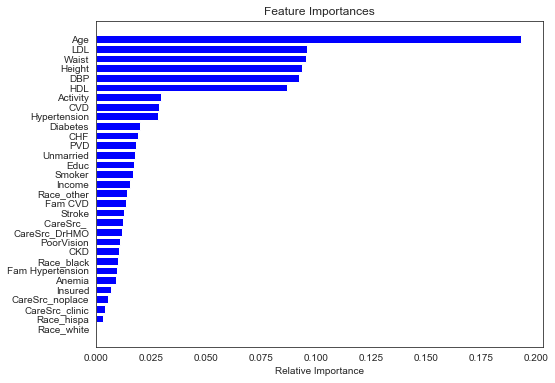

In [22]:
plt.figure(figsize=(8,6))
sns.set_style('white')

features = df_post_eda.columns
importances = model_RF_eda.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Reduce Further based on importances

In [23]:
## Use only higher-importance variables in importance plot above
df_post_eda = df_final[['Age', 'Height', 'Waist', 'DBP', 'LDL', 'HDL', 'Activity', 'Hypertension', 'CVD', 'CKD']]

## Split data (with dummy variables) into train/test sets
X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_RF_eda = RandomForestClassifier(random_state = 203)
model_RF_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_RF_eda = model_RF_eda.predict(X_test)

model_eval(model_RF_eda, y_test, predictions_RF_eda)

Confusion Matrix: 
       0   1
0  1632  18
1   127  23 

Proft:  -83800.0
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.99,0.96,1650.0
1,0.56,0.15,0.24,150.0
Avg/Total,0.90,0.92,0.90,1800.0


# Gradient Boosting: XGBoost

### <font color = grey> Baseline

In [24]:
## Split data (with dummy variables) into train/test sets
X = df_final.drop('CKD',axis=1)
# X = preprocessing.scale(df_final.drop('CKD',axis=1))
y = df_final['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_XGB_all = XGBClassifier(random_state = 203)
model_XGB_all.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_XGB_all = model_XGB_all.predict(X_test)

model_eval(model_XGB_all, y_test, predictions_XGB_all)

Confusion Matrix: 
       0   1
0  1616  34
1   119  31 

Proft:  42600.0
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.98,0.95,1650.0
1,0.48,0.21,0.29,150.0
Avg/Total,0.89,0.92,0.90,1800.0


### <font color = grey> Feature Engineering - Filter Method

In [25]:
## Remove the variables found fromd EDA 
df_post_eda = df_final.drop(['SBP', 'Total Chol', 'Weight', 'BMI', 'Dyslipidemia', 'Fam Diabetes', 'Female', 'Obese'],
                                  axis = 1)

## Split data (with dummy variables) into train/test sets
X = df_post_eda.drop('CKD',axis=1)
# X = preprocessing.scale(df_post_eda.drop('CKD',axis=1))
y = df_post_eda['CKD'].astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 203)

## Create model instance and fit model to training data
model_XGB_eda = XGBClassifier(random_state = 203)
model_XGB_eda.fit(X_train, y_train)

## Use fitted model to make predictions on test data
predictions_XGB_eda = model_XGB_eda.predict(X_test)

model_eval(model_XGB_eda, y_test, predictions_XGB_eda)

Confusion Matrix: 
       0   1
0  1614  36
1   119  31 

Proft:  42400.0
F1 Score:  0.9 

Model Results:


,Precision,Recall,F1-score,Support
0,0.93,0.98,0.95,1650.0
1,0.46,0.21,0.29,150.0
Avg/Total,0.89,0.91,0.90,1800.0


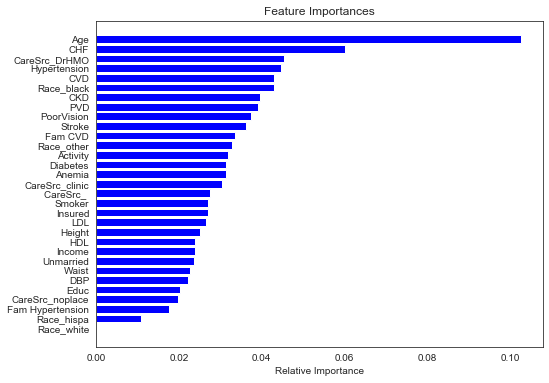

In [26]:
plt.figure(figsize=(8,6))
sns.set_style('white')

features = df_post_eda.columns
importances = model_XGB_eda.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Summary of results

In [29]:
results = []

results.append(model_eval_for_df('Log Reg: Base', model_LR_all, y_test, predictions_LR_all))
results.append(model_eval_for_df('Log Reg: EDA', model_LR_eda, y_test, predictions_LR_eda))
results.append(model_eval_for_df('Rand Forrest: Base', model_RF_all, y_test, predictions_RF_all))
results.append(model_eval_for_df('Rand Forrest: EDA', model_RF_eda, y_test, predictions_RF_eda))
results.append(model_eval_for_df('XGBoost: Base', model_XGB_all, y_test, predictions_XGB_all))
results.append(model_eval_for_df('XGBoost: EDA', model_XGB_eda, y_test, predictions_XGB_eda))

pd.DataFrame(results, columns = ['Model Version', 'F1-Score', 'AUC','Profit']).sort_values(['F1-Score', 'AUC', 'Profit'], ascending = False)

,Model Version,F1-Score,AUC,Profit
0,Log Reg: Base,0.91,0.605,91400.0
4,XGBoost: Base,0.90,0.593,42600.0
1,Log Reg: EDA,0.90,0.593,27700.0
5,XGBoost: EDA,0.90,0.592,42400.0
3,Rand Forrest: EDA,0.90,0.571,-83800.0
2,Rand Forrest: Base,0.89,0.545,-226700.0


___
___

# Future Scope

Additions I plan to work on in the future:

- More detail in write-up about topics/concepts used
    - AUC


- Code improvements / efficiencies
    - Refine/Combine custom functions 
        - (add AUC)


- Additional Feature Engineering
    - Wrapper:  RFE
    - Embedded: Lasso


- Additional Model Tuning:
    - Grid Search


- Imbalanced problem adjustments
    - Over/Under sample, SMOTE
    
